In [435]:
#import keras
from IPython import get_ipython
get_ipython().magic('reset -sf') 

import nltk
import pandas as pd
import numpy as np
import re
import codecs
import gc
from nltk.corpus import wordnet
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pivottablejs import pivot_ui
import random 
from nltk.probability import FreqDist
gc.collect()
    

0

In [436]:
inputFile="../data/cleaned/outputFile2-0-500000.csv" 
df = pd.read_csv(inputFile, dtype = {"primary_price" : "string"})
df = df.drop(['id'], axis=1)
df=df[0:10000]

# our categories and their related words
classes=['unisex', 'men', 'women', 'kid', 'baby']
manNet=['man','men', 'male', 'gentleman', 'gent','masculine',' manlike', ' mannish']
womanNet=['woman', 'women', 'lady', 'female' 'ladies', 'girl','feminine','unmacho','metrosexual' ]
babyNet= ['baby','toddler','infant', 'babe', 'bambino', 'infant', 'neonate', 'newborn']
kidNet=['kid','child', 'children', 'child', 'youth', 'joni','schoolchild', 'schoolgirl', 'schoolkid','junior']
unisexNet=['unisex','androgynous', 'genderless', 'unisexual']

all_Nets_list= [manNet,womanNet,babyNet,kidNet,unisexNet ]


In [437]:
# Helper Functions

def plot_class_distribution (data_frame, groupby_feature,class_name, starting_index=0):
    grouped  = data_frame.groupby([class_name]) 
    values=grouped[groupby_feature].agg(np.size)[starting_index:]  
    labels =  values.index.tolist()  
    y_pos = np.arange(len(labels))
    plt.bar(y_pos, values)
    plt.xticks(y_pos, labels)
    plt.xlabel('Product categories')
    plt.ylabel('Number of Products')
    plt.show()
    print(data_frame[class_name].value_counts())


In [438]:
#Cleaning the dataset


#map NLTK’s POS tags
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)


#Lemmatize Normalization
def normalize (tokens):
    lem = WordNetLemmatizer()
    return [lem.lemmatize(token,pos=get_wordnet_pos(token)) for token in tokens]

#clean up  tokenized  data
def standardize_tokens (tokens):
    return [token.lower() for token in tokens]

#Few regular expressions to clean up  text data
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r".com", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.replace(r"nan", "")
    df[text_field] = df[text_field].str.lower()
    #tokenize text
    df[text_field] = df[text_field].apply(word_tokenize)
    #remove stop words
    stop_words=set(stopwords.words("english"))
    df[text_field] = df[text_field].apply(lambda x: [item for item in x if item not in stop_words] )
    #normalize text
    df[text_field] = df[text_field].apply(normalize)
        
   


In [439]:
df.head()

,product_type,vendor_name,title,store_domain,store_product_brand_domain,description,primary_price,full_store_product_url
0,Cookware,Hestan,Hestan Nanobond Stainless 3qt/2.8L covered sau...,atlantagrillcompany.com,hestanculinary.com,NaN,290.0,https://atlantagrillcompany.com/products/hesta...
1,Cookware,Hestan,Hestan Nanobond Titanium Stockpot 8-Quart,atlantagrillcompany.com,hestanculinary.com,NaN,450.0,https://atlantagrillcompany.com/products/hesta...
2,Skillets,Hestan,"Hestan Nanobond 8.5"" Open Skillet",dasallas.com,hestanculinary.com,NaN,189.95,https://dasallas.com/products/hestan-nanobond-...
3,Saucepans & Sauciers,Hestan,Hestan Nanobond 5-Quart Covered Essential Pan ...,dasallas.com,hestanculinary.com,NaN,499.95,https://dasallas.com/products/hestan-nanobond-...
4,Cookware,Hestan,Hestan ProBond Forged Stainless Steel Ultimate...,atlantagrillcompany.com,hestanculinary.com,NaN,799.99,https://atlantagrillcompany.com/products/hesta...


In [440]:

df['title']=df['title'].astype(str)
df['product_type']=df['product_type'].astype(str)
df['description']=df['description'].astype(str)
df['store_domain']=df['store_domain'].astype(str)
df['vendor_name']=df['vendor_name'].astype(str)
df['store_product_brand_domain']=df['store_product_brand_domain'].astype(str)
 
# df['all_text_original'] = df.values.sum(axis=1)
#df['all_text_original'] = df.apply( str.join( " " ))

df['all_text_original'] = df['product_type']+" "+df['vendor_name']+" "+df['title']+" "+df['store_domain']+" "+df['store_product_brand_domain']+" "+df['description']
df['vendor_name_original'] = df['vendor_name'].str.lower()

standardize_text(df, 'product_type')
standardize_text(df, 'vendor_name')
standardize_text(df, 'title')
standardize_text(df, 'store_domain')
standardize_text(df, 'description')
standardize_text(df,'store_product_brand_domain')

#combine all token in all columns into one column
#df['all_tokens'] = df.values[:,['product_type','vendor_name', 'title', 'store_domain', 'description']].sum(axis=1)
df['all_tokens'] = df.values[:,0:6].sum(axis=1)

 
    

# Round 1: Label  records based on the occurance of the keywords

##  Frequency of the categories and their synonyms in the product information 


In [441]:
#count occurence of keyword in the list
def countFreq (product_info, keywordList):
    total_count =0
    for item in product_info:
      total_count += keywordList.count(item)
    return total_count


        

df['unisex'] = df['all_tokens'].apply(countFreq,keywordList=unisexNet)   
df['men'] = df['all_tokens'].apply(countFreq,keywordList=manNet) 
df['women'] = df['all_tokens'].apply(countFreq,keywordList=womanNet)  
df['baby'] = df['all_tokens'].apply(countFreq,keywordList=babyNet)  
df['kid'] = df['all_tokens'].apply(countFreq,keywordList=kidNet)
  
df['class']=  '-1'



## Choose the label with the highest occurance of the keyword 

In [442]:
# choose the label with the highest occurance of the keyword 
def findLabel(row): 
        maxCount=max(row)
        if maxCount> 0:
            maxLabel= row[row == maxCount].index[0] 
        else:
            maxLabel='-1'
        return maxLabel
    
df.loc[:,'class']=df.loc[:,classes].apply(findLabel,axis=1) 


## The distribution of classes including Nan

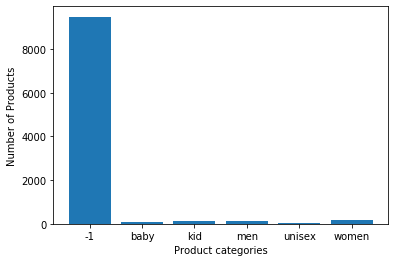

-1        9477
women      162
men        137
kid        126
baby        81
unisex      17
Name: class, dtype: int64


In [443]:
plot_class_distribution (df, 'product_type','class', starting_index=0)

## The distribution of classes excluding Nan

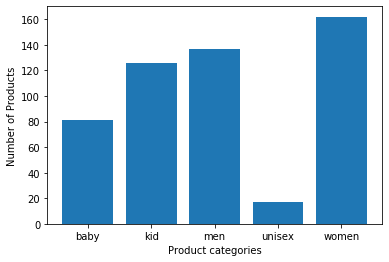

-1        9477
women      162
men        137
kid        126
baby        81
unisex      17
Name: class, dtype: int64


In [444]:
plot_class_distribution (df, 'product_type','class', starting_index=1)

##  Choose some randoms record to check the labeling in this round

In [445]:
#keep trackes of record labeled in this round
labeled_data_index_r1=df[df['class']!= '-1'].index.to_list()

#labeled_data=df[df['class']!= '-1'].copy()
#unlabeled_data_index=df.index.difference(labeled_data.index)

random_records=random.sample(labeled_data_index_r1, k=10) 
test=df.loc[random_records, ['class','product_type','full_store_product_url' ,'all_text_original']]
test.to_csv("../data/validate/test_random_labeled_data_Round1.csv", index=True)


In [446]:

print("Number of records labeled in round 1:", len(labeled_data_index_r1))
print("Number of records not labeled in round 1:",df.shape[0]-len(labeled_data_index_r1))

Number of records labeled in round 1: 523
Number of records not labeled in round 1: 9477


# Export Labeled Data

In [447]:
df['all_text']= df['all_tokens'].apply(lambda x: " ".join(x))
df.to_csv("../data/labeled/labeled_dataV1.csv", index=True)
 


## Round 2: Find the most common keywords in product information and label records containg those keywords


###  1) Define commmon keywords for each category

In [448]:
unisexProduct= ['electronics', 'phone','fruit','movie','vegetable', 
                'seafood','ipad','video','music','book', 'dairy',
                'egg', 'fridge', 'phone', 'supplement', 'cable', 
                'cookware', 'cook', 'novel', 'bike','headphone',
               'appliance','battery', 'vitamin','fence', 'garden',
                'speaker','camera', 'kitchen', 'radio', 'backpack'
                'frozen', 'food', 'household', 'safety', 'skate', 'tuna' ]

womanProduct=['jewellery', 'pregnancy', 'make up', 'nail polish', 
              'eye shadow', 'skirt','Manicure', 'Pedicure', 'jewellery'  ]

menProduct= ['shave', 'tuxedo', 'tie'] 


kidProduct=['school', 'disney', 'spider', 'barbie','doll'  ]

babyProduct=['Pacifier' ,'Strollers', 'diapers', 'potty', 'walkers',
             'playmat',  'Car Seat', 'lip liner', 'Babyliss', 'maternity', 
             'Teether', 'nursery', 'carrier', 'crib', 'Rattle', 'sleeper']




#lemmitize and standardize the all the categories lists
unisexProduct=normalize(unisexProduct)
unisexProduct=standardize_tokens(unisexProduct)
menProduct=normalize(menProduct)
menProduct=standardize_tokens(menProduct)
womanProduct=normalize(womanProduct)
womanProduct=standardize_tokens(womanProduct)
kidProduct=normalize(kidProduct)
kidProduct=standardize_tokens(kidProduct) 
babyProduct=normalize(babyProduct)
babyProduct=standardize_tokens(babyProduct) 

all_categories_lists=[unisexProduct,   menProduct ,  womanProduct ,  kidProduct ,  babyProduct]
all_keyword_lists= all_Nets_list+all_categories_lists

all_keyword_set= set()
for list_a in all_keyword_lists:
    #all_keyword_set = all_keyword_set.union(set(list_a))
    all_keyword_set.update(set(list_a))
    



### 2) Find most commmon words in product information which are not included in the categories lists

####   Let's inspect word and vocabulary of our data set

In [449]:
#combine all rows' tokens  into one list
all_words=list([a for b in df['all_tokens'].tolist() for a in b])
all_words=list(filter(lambda a: a not in [',', '(', ')', "'", '"', ' '], all_words))


In [450]:
#Find the most frequent words which are not included  categories lists
fdist = FreqDist(all_words)
for word,number in fdist.most_common(30):
    if word not in all_keyword_set:
        print (word, end = ', ')

    

petra, zebra, naked, au, aldi, groceryvan, r, viz, vestil, w2wfurnishings, 187, top, pad, orbea, '', gregory, retail, dress, industry, 2, 187killerpads, 1, black, mineral, vol, killer, gregorypacks, 3, co, 

#### None of these keywords can help us to label more products. so, let's move to  label the records based on our selected common keywords

### 3) Label records containg common keywords

In [451]:
#find the total frequency of a list of keywords in a tokenized list 
def count_occurance_keyword ( tokenized_list, category_list ) :
        count=0
        text_data= ' '.join( tokenized_list)+" "
        for keyword in category_list:
                count = text_data.count(keyword+" ") 
        return count     
    
def findLabel_commonKeywords(dataFrame, feature): 
    count_unisex = count_occurance_keyword(dataFrame[feature], unisexProduct) 
    count_men   =  count_occurance_keyword(dataFrame[feature], menProduct) 
    count_woman  = count_occurance_keyword(dataFrame[feature], womanProduct) 
    count_kid    = count_occurance_keyword(dataFrame[feature], kidProduct) 
    count_baby   = count_occurance_keyword(dataFrame[feature], babyProduct) 
    
    index=['unisex', 'men', 'women', 'kid', 'baby']
    counters=[count_unisex, count_men, count_woman,count_kid,count_baby]
    frequency= pd.Series(counters, index=index)
    
    # find label with maximum frequency
    max_frequency= max(frequency)
    max_label= frequency.idxmax() if max_frequency> 0 else '-1' 
    return max_label


#notLabled = df[ df['class'] == '-1' ]  
not_labled_index=  df['class'] == '-1' 
df.loc[not_labled_index, 'class'] = df.loc[not_labled_index,:].apply(findLabel_commonKeywords, axis=1,args=['all_tokens']) 



In [452]:
#Ignore thi line, just to test funstion
#count_occurance_keyword(['tie','men', 'baby', 'shaver','shaves', 'tie','shave', 'tiered'], ['tie', 'shave']) 

#  Find records labeled in this round

In [453]:
#keep trackes of record labeled in this round
labeled_data_index=df[df['class']!= '-1'].index.to_list()
print(len(labeled_data_index))
labeled_data_index_r2 = [i for i in labeled_data_index if i not in labeled_data_index_r1]
print(len(labeled_data_index_r2))

758
235


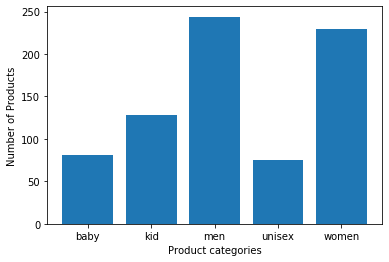

-1        9242
men        244
women      230
kid        128
baby        81
unisex      75
Name: class, dtype: int64


In [454]:
plot_class_distribution (df, 'product_type','class', starting_index=1)

# Export Labeled Data

In [455]:

df.to_csv("../data/labeled/labeled_dataV2.csv", index=True)
 


##  Choose some random records that are labeled in this round in order to check the labeling performance

In [456]:
random_records=random.sample(labeled_data_index_r2, k=10) 
test=df.loc[random_records, ['class','product_type','full_store_product_url' ,'all_text_original']]
test.to_csv("../data/validate/test_random_labeled_data_Round2.csv", index=True)

In [457]:


print("Number of records labeled in round 2:", len(labeled_data_index_r2))
print("Number of records not labeled in round 2:",df.shape[0]-len(labeled_data_index_r2))

Number of records labeled in round 2: 235
Number of records not labeled in round 2: 9765


#  Round 3: Labeling more records based on vendor names

If products from a vendor all belong to one particular category (given that at least 10 products are listed), we can assign that category to other products from the same vendor

In [458]:
#pivot_ui(labeled_data )

In [459]:
homo_brands= {}
labeled_data=df[df['class']!= '-1'].copy()
grouped  = labeled_data.groupby(['vendor_name_original'])
for key, group in grouped:
   class_group = grouped.get_group(key).groupby(['class']) 
   #print(key, len(class_group ), class_group['class'].count() )
   # if all products belong to one category
   if len(class_group)==1:
      # If at least 10 products are listed for a company
      if  (class_group['class'].count()[0]) > 10 :
         homo_brands[key]= list(class_group.groups.keys())[0]

print(homo_brands)

{'187': 'kid', '187 killer pads': 'kid', 'damsel': 'women', 'jose serrats': 'unisex', 'viz': 'men', 'viz media': 'men'}


In [460]:
homo_vendor_bool=  df['vendor_name_original'].apply( lambda x: x in list(homo_brands.keys())) 
not_labled_bool=   df['class'] == '-1'
#records which are not labeled yet and belong to homo vendor
homo_notLabeld_bool=np.logical_and(not_labled_bool, homo_vendor_bool)
homo_notLabeld_index= df[homo_notLabeld_bool].index

pd.DataFrame({'homo_vendor': homo_vendor_bool, 'not_labled_bool': not_labled_bool,'homo_notLabeld_bool':homo_notLabeld_bool  })
display(df) 

,product_type,vendor_name,title,store_domain,store_product_brand_domain,description,primary_price,full_store_product_url,all_text_original,vendor_name_original,all_tokens,unisex,men,women,baby,kid,class,all_text
0,[cookware],[hestan],"[hestan, nanobond, stainless, 3qt, 2, 8l, cove...",[atlantagrilpany],[hestanculinary],[],290.0,https://atlantagrillcompany.com/products/hesta...,Cookware Hestan Hestan Nanobond Stainless 3qt/...,hestan,"[cookware, hestan, hestan, nanobond, stainless...",0,0,0,0,0,-1,cookware hestan hestan nanobond stainless 3qt ...
1,[cookware],[hestan],"[hestan, nanobond, titanium, stockpot, 8, quart]",[atlantagrilpany],[hestanculinary],[],450.0,https://atlantagrillcompany.com/products/hesta...,Cookware Hestan Hestan Nanobond Titanium Stock...,hestan,"[cookware, hestan, hestan, nanobond, titanium,...",0,0,0,0,0,-1,cookware hestan hestan nanobond titanium stock...
2,[skillet],[hestan],"[hestan, nanobond, 8, 5, '', open, skillet]",[dasallas],[hestanculinary],[],189.95,https://dasallas.com/products/hestan-nanobond-...,"Skillets Hestan Hestan Nanobond 8.5"" Open Skil...",hestan,"[skillet, hestan, hestan, nanobond, 8, 5, '', ...",0,0,0,0,0,-1,skillet hestan hestan nanobond 8 5 '' open ski...
3,"[saucepan, sauciers]",[hestan],"[hestan, nanobond, 5, quart, cover, essential,...",[dasallas],[hestanculinary],[],499.95,https://dasallas.com/products/hestan-nanobond-...,Saucepans & Sauciers Hestan Hestan Nanobond 5-...,hestan,"[saucepan, sauciers, hestan, hestan, nanobond,...",0,0,0,0,0,-1,saucepan sauciers hestan hestan nanobond 5 qua...
4,[cookware],[hestan],"[hestan, probond, forge, stainless, steel, ult...",[atlantagrilpany],[hestanculinary],[],799.99,https://atlantagrillcompany.com/products/hesta...,Cookware Hestan Hestan ProBond Forged Stainles...,hestan,"[cookware, hestan, hestan, probond, forge, sta...",0,0,0,0,0,-1,cookware hestan hestan probond forge stainless...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,[],[],"[hp, 1fk04aa, classic, backpack, 15, 6, inch, ...","[loqta, p]","[loqta, p]",[],120.0,NaN,الكمبيوتر والمكتب متجر لقطة HP 1FK04AA Classic...,متجر لقطة,"[hp, 1fk04aa, classic, backpack, 15, 6, inch, ...",0,0,0,0,0,-1,hp 1fk04aa classic backpack 15 6 inch laptop l...
9996,[],[],"[4, 1, pritech]","[loqta, p]","[loqta, p]",[],135.0,NaN,الكترونيات متجر لقطة سشوار و مجفف شعر 4 في 1 P...,متجر لقطة,"[4, 1, pritech, loqta, p, loqta, p]",0,0,0,0,0,-1,4 1 pritech loqta p loqta p
9997,[],[],[],"[loqta, p]","[loqta, p]",[],50.0,NaN,الصحة والجمال متجر لقطة غسول حب الشباب من هولي...,متجر لقطة,"[loqta, p, loqta, p]",0,0,0,0,0,-1,loqta p loqta p
9998,[],[],[],"[loqta, p]","[loqta, p]",[],110.0,NaN,رياضة ولياقة متجر لقطة مشد مصحح لانحناء الظهر ...,متجر لقطة,"[loqta, p, loqta, p]",0,0,0,0,0,-1,loqta p loqta p


In [461]:
print("not labeled \n",df[not_labled_bool].index)
print("homo \n",df[homo_vendor_bool].index)
print("homo and notlabeled \n",df[homo_notLabeld_bool].index)


not labeled 
 Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            9990, 9991, 9992, 9993, 9994, 9995, 9996, 9997, 9998, 9999],
           dtype='int64', length=9242)
homo 
 Int64Index([ 279,  280,  284,  293,  298,  300,  309,  330,  331,  335,
            ...
            9259, 9260, 9261, 9262, 9263, 9264, 9265, 9266, 9267, 9268],
           dtype='int64', length=1163)
homo and notlabeled 
 Int64Index([ 578,  593,  598,  603,  610,  617,  632,  637,  642,  649,
            ...
            9255, 9257, 9259, 9260, 9261, 9263, 9265, 9266, 9267, 9268],
           dtype='int64', length=986)


In [462]:
print(df['class'].value_counts())

def get_homo_class ( x ):
    vendor=x['vendor_name_original']
    #print(vendor, homo_brands[vendor])
    return homo_brands[vendor]
    
df.loc[homo_notLabeld_index, 'class'] = df.loc[homo_notLabeld_index,:].apply(get_homo_class, axis=1)
print(df['class'].value_counts())
display(df)

-1        9242
men        244
women      230
kid        128
baby        81
unisex      75
Name: class, dtype: int64
-1        8256
men        767
kid        581
women      240
baby        81
unisex      75
Name: class, dtype: int64


,product_type,vendor_name,title,store_domain,store_product_brand_domain,description,primary_price,full_store_product_url,all_text_original,vendor_name_original,all_tokens,unisex,men,women,baby,kid,class,all_text
0,[cookware],[hestan],"[hestan, nanobond, stainless, 3qt, 2, 8l, cove...",[atlantagrilpany],[hestanculinary],[],290.0,https://atlantagrillcompany.com/products/hesta...,Cookware Hestan Hestan Nanobond Stainless 3qt/...,hestan,"[cookware, hestan, hestan, nanobond, stainless...",0,0,0,0,0,-1,cookware hestan hestan nanobond stainless 3qt ...
1,[cookware],[hestan],"[hestan, nanobond, titanium, stockpot, 8, quart]",[atlantagrilpany],[hestanculinary],[],450.0,https://atlantagrillcompany.com/products/hesta...,Cookware Hestan Hestan Nanobond Titanium Stock...,hestan,"[cookware, hestan, hestan, nanobond, titanium,...",0,0,0,0,0,-1,cookware hestan hestan nanobond titanium stock...
2,[skillet],[hestan],"[hestan, nanobond, 8, 5, '', open, skillet]",[dasallas],[hestanculinary],[],189.95,https://dasallas.com/products/hestan-nanobond-...,"Skillets Hestan Hestan Nanobond 8.5"" Open Skil...",hestan,"[skillet, hestan, hestan, nanobond, 8, 5, '', ...",0,0,0,0,0,-1,skillet hestan hestan nanobond 8 5 '' open ski...
3,"[saucepan, sauciers]",[hestan],"[hestan, nanobond, 5, quart, cover, essential,...",[dasallas],[hestanculinary],[],499.95,https://dasallas.com/products/hestan-nanobond-...,Saucepans & Sauciers Hestan Hestan Nanobond 5-...,hestan,"[saucepan, sauciers, hestan, hestan, nanobond,...",0,0,0,0,0,-1,saucepan sauciers hestan hestan nanobond 5 qua...
4,[cookware],[hestan],"[hestan, probond, forge, stainless, steel, ult...",[atlantagrilpany],[hestanculinary],[],799.99,https://atlantagrillcompany.com/products/hesta...,Cookware Hestan Hestan ProBond Forged Stainles...,hestan,"[cookware, hestan, hestan, probond, forge, sta...",0,0,0,0,0,-1,cookware hestan hestan probond forge stainless...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,[],[],"[hp, 1fk04aa, classic, backpack, 15, 6, inch, ...","[loqta, p]","[loqta, p]",[],120.0,NaN,الكمبيوتر والمكتب متجر لقطة HP 1FK04AA Classic...,متجر لقطة,"[hp, 1fk04aa, classic, backpack, 15, 6, inch, ...",0,0,0,0,0,-1,hp 1fk04aa classic backpack 15 6 inch laptop l...
9996,[],[],"[4, 1, pritech]","[loqta, p]","[loqta, p]",[],135.0,NaN,الكترونيات متجر لقطة سشوار و مجفف شعر 4 في 1 P...,متجر لقطة,"[4, 1, pritech, loqta, p, loqta, p]",0,0,0,0,0,-1,4 1 pritech loqta p loqta p
9997,[],[],[],"[loqta, p]","[loqta, p]",[],50.0,NaN,الصحة والجمال متجر لقطة غسول حب الشباب من هولي...,متجر لقطة,"[loqta, p, loqta, p]",0,0,0,0,0,-1,loqta p loqta p
9998,[],[],[],"[loqta, p]","[loqta, p]",[],110.0,NaN,رياضة ولياقة متجر لقطة مشد مصحح لانحناء الظهر ...,متجر لقطة,"[loqta, p, loqta, p]",0,0,0,0,0,-1,loqta p loqta p


#  Find records labeled in this round

In [463]:
#keep trackes of record labeled in this round
labeled_data_index=df[df['class']!= '-1'].index.to_list()
print(len(labeled_data_index))
labeled_data_index_before=labeled_data_index_r1+labeled_data_index_r2
labeled_data_index_r3 = [i for i in labeled_data_index if i not in labeled_data_index_before]
print(len(labeled_data_index_r3))

1744
986


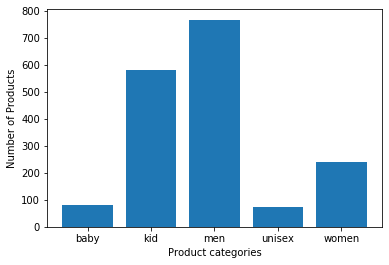

-1        8256
men        767
kid        581
women      240
baby        81
unisex      75
Name: class, dtype: int64


In [464]:
plot_class_distribution (df, 'product_type','class', starting_index=1)

# Export Labeled Data

In [465]:

df.to_csv("../data/labeled/labeled_dataV3.csv", index=True)
 


In [466]:
display(labeled_data.head())

,product_type,vendor_name,title,store_domain,store_product_brand_domain,description,primary_price,full_store_product_url,all_text_original,vendor_name_original,all_tokens,unisex,men,women,baby,kid,class,all_text
30,[],"[trace, mineral, research]","[trace, mineral, research, complete, child, ch...",[supplementfirst],[traceminerals],[],16.59,https://supplementfirst.com/products/trace-min...,nan Trace Minerals Research Trace Minerals Res...,trace minerals research,"[trace, mineral, research, trace, mineral, res...",0,0,0,0,2,kid,trace mineral research trace mineral research ...
52,[],"[trace, mineral, research]","[trace, mineral, research, kid, multi]",[supplementfirst],[traceminerals],[],20.89,https://supplementfirst.com/products/trace-min...,nan Trace Minerals Research Trace Minerals Res...,trace minerals research,"[trace, mineral, research, trace, mineral, res...",0,0,0,0,1,kid,trace mineral research trace mineral research ...
94,[],"[trace, mineral]","[kid, multi]",[organickingdom],[traceminerals],[],15.99,https://organickingdom.com/products/kids-multi...,nan Trace Minerals Kids Multi organickingdom.c...,trace minerals,"[trace, mineral, kid, multi, organickingdom, t...",0,0,0,0,1,kid,trace mineral kid multi organickingdom tracemi...
95,[],"[trace, mineral, research]","[trace, mineral, research, concentrace, kid, '...",[oakstreetvitamins],[traceminerals],[],22.39,https://oakstreetvitamins.com/products/trace-m...,nan Trace Minerals Research Trace Minerals Res...,trace minerals research,"[trace, mineral, research, trace, mineral, res...",0,0,0,0,1,kid,trace mineral research trace mineral research ...
97,"[personal, care]","[trace, mineral]","[concentrace, kid, 's, trace, mineral, drop]",[xsnonline],[traceminerals],[],15.38,https://xsnonline.com/products/concentrace-kid...,Personal Care Trace Minerals ConcenTrace Kid's...,trace minerals,"[personal, care, trace, mineral, concentrace, ...",0,0,0,0,1,kid,personal care trace mineral concentrace kid 's...


##  Choose some random records that are labeled in thi round in order to check the labeling performance

In [467]:
# labeled_data=unlabeled_data[unlabeled_data['class']!= '-1'].copy()
# unlabeled_data=df[df['class']== '-1'].copy()
# random_records=random.sample(labeled_data.index.to_list(), k=40) 
# test=labeled_data.loc[random_records, ['class','product_type','full_store_product_url' ,'all_text_original']]
# test.to_csv("../data/validate/test_random_labeled_data_Round3.csv", index=True)

##  Choose some random records that are labeled in this round in order to check the labeling performance

In [468]:
random_records=random.sample(labeled_data_index_r3, k=10) 
test=df.loc[random_records, ['class','product_type','full_store_product_url' ,'all_text_original']]
test.to_csv("../data/validate/test_random_labeled_data_Round3.csv", index=True)

In [469]:


print("Number of records labeled in round 3:", len(labeled_data_index_r3))
print("Number of records not labeled in round 3:",df.shape[0]-len(labeled_data_index_r3))

Number of records labeled in round 3: 986
Number of records not labeled in round 3: 9014


In [470]:
#Note
#https://touchdolls.com/ is for ladies not kids
#tying lemm -> tie